### Language Model to predict next word - [article](https://adventuresinmachinelearning.com/keras-lstm-tutorial/), [code](https://github.com/adventuresinML/adventures-in-ml-code/blob/master/keras_lstm.py)

Uses Keras and RNN

In [1]:
# Download Penn Tree Bank dataset
!wget http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz
  
# Extract it
!tar xf simple-examples.tgz
!mv simple-examples ptb
!ls -l ptb/data/

--2019-07-26 05:42:51--  http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz
Resolving www.fit.vutbr.cz (www.fit.vutbr.cz)... 147.229.9.23, 2001:67c:1220:809::93e5:917
Connecting to www.fit.vutbr.cz (www.fit.vutbr.cz)|147.229.9.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34869662 (33M) [application/x-gtar]
Saving to: ‘simple-examples.tgz’

simple-examples.tgz 100%[===================>]  33.25M  21.1MB/s    in 1.6s    

2019-07-26 05:42:54 (21.1 MB/s) - ‘simple-examples.tgz’ saved [34869662/34869662]

total 17256
-rw-r--r-- 1 491 root   884846 Feb 23  2011 ptb.char.test.txt
-rw-r--r-- 1 491 root 10034964 Feb 23  2011 ptb.char.train.txt
-rw-r--r-- 1 491 root   786084 Feb 23  2011 ptb.char.valid.txt
-rw-r--r-- 1 491 root   449945 Aug  6  2010 ptb.test.txt
-rw-r--r-- 1 491 root  5101618 Aug  6  2010 ptb.train.txt
-rw-r--r-- 1 491 root   399782 Aug  6  2010 ptb.valid.txt
-rw-r--r-- 1 491 root      609 Sep 13  2011 README


In [11]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import to_categorical, import plot_model
import numpy as np

# ptb.train.txt - Training free-form text document
# ptb.valid.txt - Validation free-form text document
# ptb.test.txt - Test free-form text document
data_path = "ptb/data/"
training_file = data_path + "ptb.train.txt"
validation_file = data_path + "ptb.valid.txt"
test_file = data_path + "ptb.test.txt"

#----------------------------------------------
# Read the text file, split the text into a sequence of words and 
# return it as a large list
#----------------------------------------------
def read_words (data_file):
  with open(data_file, "r") as fp:
    text = fp.read()
    
  # Replace all newline characters with an End-of-sentence token
  eos = '<eos>'
  text = text.replace('\n', eos)
  
  words = text.split ()
  return (words)

#----------------------------------------------
# Given a corpus as a list of words, create a vocab as a sorted list of 
# unique words in the corpus. Also create a vocab_dict that maps each word
# to a word index
#----------------------------------------------
def prepare_vocab (words):
  vocab_set = set()
  
  # Set of unique words in the vocabulary
  vocab_set.update(words)
  # Sort and convert Set -> List
  vocab = sorted(list(vocab_set))
  
  # Dictionary of {word: word_index}
  vocab_dict = {w:i for i, w in enumerate(vocab)}
  
  return (vocab, vocab_dict)

#----------------------------------------------
# Word -> index utility function
#----------------------------------------------
def word2idx (vocab_dict, word):
  return (vocab_dict [word])

#----------------------------------------------
# Index -> word utility function
#----------------------------------------------
def idx2word (vocab, i):
  return (vocab[i])

#----------------------------------------------
# Take the list of words 
#        ['Hello', 'this', 'is', 'a', 'car', '<eos>', Today', 'is', ...]
# and convert them into word indices
#        ['47', '674', '927', '27', '3296', '4', '4822', '927', ...]
# using the vocab_dict
#----------------------------------------------
def word_indices (words, vocab_dict):
  word_idxs = [word2idx(vocab_dict, word) for word in words]
  return (word_idxs)

def load_data (training_file, validation_file, test_file):
  words = read_words(training_file)
  vocab, vocab_dict = prepare_vocab (words)
  word_idxs = word_indices (words, vocab_dict)
  
  # Build the vocab only with the training data
  # Now read and convert the validation and test data, using that vocab
  
  validation_words = read_words(validation_file)
  validation_word_idxs = word_indices (validation_words, vocab_dict)
  
  test_words = read_words(test_file)
  test_word_idxs = word_indices (test_words, vocab_dict)
  
  return (words, vocab, vocab_dict, word_idxs, validation_word_idxs, test_word_idxs)

words, vocab, vocab_dict, word_idxs, validation_word_idxs, test_word_idxs = load_data (training_file, validation_file, test_file)
vocab_size = len(vocab)

print (words[:10], word_idxs[:10])
print (validation_word_idxs[:10], test_word_idxs[:10])
print (vocab_size, vocab[40:50], list(vocab_dict.items())[40:50])

['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec'] [237, 807, 950, 1325, 1476, 1691, 3773, 3920, 4067, 4380]
[1993, 5502, 9680, 9119, 5816, 9018, 8946, 48, 5225, 1678] [6017, 4764, 9705, 5860, 1005, 5754, 43, 1279, 9801, 9012]
10000 ['45-year-old', '500-stock', '52-week', '<eos>', '<unk>', 'N', '\\*', '\\*\\*', 'a', 'a$'] [('45-year-old', 40), ('500-stock', 41), ('52-week', 42), ('<eos>', 43), ('<unk>', 44), ('N', 45), ('\\*', 46), ('\\*\\*', 47), ('a', 48), ('a$', 49)]


In [72]:
#--------------------------------------------------
# Prepare a data generator as the input data may be too large to fit into RAM
# We return:
# X of shape (batch_size, num_steps) and 
# y of shape (batch_size, num_steps, vocab_size) since it is one-hot encoded
#
# We shift each sequence in X by one position to get y eg. if the data is 'It is hot today'
# and the X sequence is 'It is hot', then y sequence is 'is hot today'
#
# During training, the default value of the slide_window parameter should be passed in
# During inference, the slide_window is likely to be passed a value of 1
#--------------------------------------------------
def data_generator(word_idxs, batch_size, num_steps, vocab_size, slide_window=None):

  # Number of words to include in a batch
  num_batch_words = batch_size * num_steps

  # Number of words to slide the window for the next batch
  # If no window is specified, the default is to start the next batch where
  # the previous one ends, by sliding the window by the number of words in the
  # batch
  slide_by = num_batch_words if slide_window == None else slide_window

  # Number of words in the input data
  num_total_words = len(word_idxs)
  
  # Loop forever since it is a generator
  while True:
    
    # The start_ptr points tells us where the next batch begins within the word data
    # The start_ptr starts from the beginning of the word data and increments 
    # by the sliding window (which, by default, is the number of words per batch)
    for start_ptr in np.arange (0, num_total_words, slide_by):
      # Make sure we don't go off the end of the data
      # When we reach the end, we truncate the last batch
      end_ptr = min (start_ptr + num_batch_words, num_total_words - 1)

      # Copy the words for this batch as a 1D array, between the start and end ptrs
      # The words for 'y' are shifted by one position
      dataX = np.array (word_idxs [start_ptr: end_ptr])
      datay = np.array (word_idxs [start_ptr + 1: end_ptr + 1])

      # If the last batch is truncated, we extend it to the required number of batch words
      # by padding it with the eos token
      padding = num_batch_words - (end_ptr - start_ptr)
      if (padding > 0):
        eos = '<eos>'
        eos_idx = word2idx (vocab_dict, eos)
        dataX = np.pad (dataX, (0, padding), mode='constant', constant_values=(eos_idx, eos_idx))
        datay = np.pad (datay, (0, padding), mode='constant', constant_values=(eos_idx, eos_idx))
      
      # Now reshape the X and y 1D array to the shape required
      # Then One-hot encode the y words
      dataX = dataX.reshape ((batch_size, num_steps))
      datay = datay.reshape ((batch_size, num_steps))
      datay = to_categorical(datay, num_classes=vocab_size)

      # Yield one batch of data
      yield (dataX, datay)
  
# test the data generator
print (word_idxs[:12])
generator = data_generator(word_idxs[:12], batch_size=2, num_steps=3, vocab_size=vocab_size)
for batch_i in range (3):
  inputs, outputs = next(generator)
  print(inputs.shape, outputs.shape)
  # Reverse one-hot to make sure that we got the same value
  y_first = np.argmax(outputs[0, 0])
  y_second = np.argmax(outputs[0, 1])
  
  print(inputs, outputs, y_first, y_second)

[237, 807, 950, 1325, 1476, 1691, 3773, 3920, 4067, 4380, 4731, 4922]
(2, 3) (2, 3, 10000)
[[ 237  807  950]
 [1325 1476 1691]] [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] 807 950
(2, 3) (2, 3, 10000)
[[3773 3920 4067]
 [4380 4731   43]] [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] 3920 4067
(2, 3) (2, 3, 10000)
[[ 237  807  950]
 [1325 1476 1691]] [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] 807 950


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 500)           5000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 500)           2002000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 500)           2002000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 500)           0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 10000)         5010000   
_________________________________________________________________
activation_3 (Activation)    (None, 30, 10000)         0         
Total params: 14,014,000
Trainable params: 14,014,000
Non-trainable params: 0
________________________________________________________________

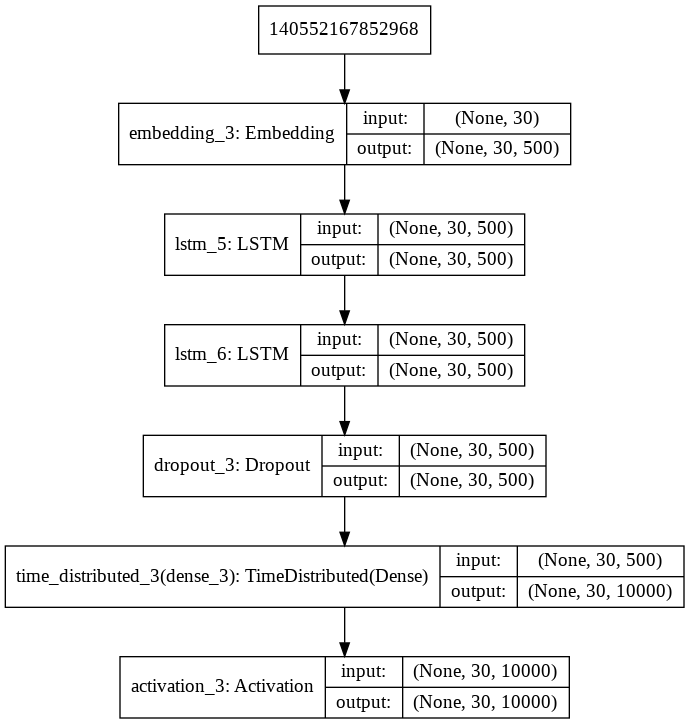

In [55]:
hidden_size = 500
use_dropout=True
batch_size = 20
num_steps = 30
num_epochs = 2

#--------------------------------------------------
# Define the model as a Sequential model
#
# The input to the embedding layer is (batch_size, num_steps) and the output is (batch_size, num_steps, hidden_size)
#--------------------------------------------------
def define_model (hidden_size, use_dropout, num_steps, vocab_size):
  model = Sequential()
  
  # Embedding layer
  model.add(Embedding(vocab_size, hidden_size, input_length=num_steps))
  
  # 2 LSTM layers - output shape of each LSTM layer is (batch_size, num_steps, hidden_size)
  # The return_sequences=True means that the LSTM cell returns all of the outputs. When we 
  # train the model, it is best to be able to compare the LSTM cell output at each time 
  # step with the next word in the sequence – in this way we get num_steps opportunities 
  # to correct errors in the model (via back-propagation) rather than just one for each sample.
  model.add(LSTM(hidden_size, return_sequences=True))
  model.add(LSTM(hidden_size, return_sequences=True))
  
  if use_dropout:
    model.add(Dropout(0.5))

  # The Time Distributed adds an independent layer for each time step in the RNN model. eg. If we 
  # have 10 time steps in a model, a TimeDistributed layer operating on a Dense layer would 
  # produce 10 independent Dense layers, one for each time step. 
  model.add(TimeDistributed(Dense(vocab_size)))
  model.add(Activation('softmax'))
  
  # summarize model
  print(model.summary())
  plot_model(model, to_file='model.png', show_shapes=True)
  return model

# define the model
model = define_model(hidden_size, use_dropout, num_steps, vocab_size)
from IPython.display import Image
Image(filename='model.png')

In [56]:
#--------------------------------------------------
# Train the model on the training and validation data and measure metrics
#--------------------------------------------------
def train_model (model, word_idxs, validation_word_idxs, num_epochs, batch_size, num_steps, vocab_size):
  optimizer = Adam()
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

  # Create a Keras callback, which are functions which Keras calls, after the end of a training epoch. 
  # A model checkpoint callback saves the model after each epoch, which can be handy for long-running training 
  checkpointer = ModelCheckpoint(filepath=data_path + '/model-{epoch:02d}.hdf5', verbose=1)
  
  # Train the model using the data generator function
  generator = data_generator(word_idxs, batch_size, num_steps, vocab_size)
  validation_generator = data_generator(validation_word_idxs, batch_size, num_steps, vocab_size)
  model.fit_generator(generator, len(word_idxs)//(batch_size*num_steps), num_epochs,
                        validation_data=validation_generator,
                        validation_steps=len(validation_word_idxs)//(batch_size*num_steps), callbacks=[checkpointer])
  
train_model (model, word_idxs, validation_word_idxs, num_epochs, batch_size, num_steps, vocab_size)

W0726 10:17:52.706173 140553482737536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0726 10:17:52.738685 140553482737536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0726 10:17:52.929614 140553482737536 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
1549/1549 [==============================] - 318s 206ms/step - loss: 6.6638 - categorical_accuracy: 0.0848 - val_loss: 5.9921 - val_categorical_accuracy: 0.1391

Epoch 00001: saving model to ptb/data//model-01.hdf5
Epoch 2/2
1549/1549 [==============================] - 315s 203ms/step - loss: 5.8198 - categorical_accuracy: 0.1580 - val_loss: 5.5359 - val_categorical_accuracy: 0.1806

Epoch 00002: saving model to ptb/data//model-02.hdf5


In [79]:
#--------------------------------------------------
# Perform inference with the trained model
#
# We start with a set of input words eg. 'I went to the store and looked for'
# This predicts a set of output words, but we pick only the last word (say 'bananas') which represents
# the 'predicted next word' in the sentence.
# In the next iteration we slide the input words by one eg. 'went to the store and looked for oranges'.
# Again we predict a set of output words and pick only the last word (say 'which')
# In the next iteration we slide the input words again eg. 'to the store and looked for oranges which'
# We repeat this and come up with our predicted words 'bananas which ...'
# Our expected words were 'oranges which ...' and our prefix context words were 'I went to the store and looked for'
#--------------------------------------------------
def inference (model, test_word_idxs, num_steps, vocab, vocab_size):
  test_generator = data_generator(test_word_idxs, batch_size=1, num_steps=num_steps, vocab_size=vocab_size, slide_window=1)
  
  print("Test data:")
  expected_words = "Expected words: "
  predicted_words = "Predicted words: "

  # Loop through the number of words to be predicted
  num_predict = 8
  for i in range(num_predict):
    # Get the next set of input words, by sliding the window one word at a time
    test_words_idxs, _ = next(test_generator)
    
    # Use it to predict the output words
    predicted_word_idxs = model.predict(test_words_idxs)

    # Take only the last word from the output and discard the rest
    predicted_lastword_idx = np.argmax(predicted_word_idxs[:, num_steps - 1, :])
    predicted_lastword = idx2word (vocab, predicted_lastword_idx)
    predicted_words += predicted_lastword + " "
    
    # For the first iteration save off all the input words which are the
    # prefix context
    if (i == 0):
      prefix_words = [idx2word (vocab, idx) for idx in test_words_idxs[0]]
      prefix_sentence = ' '.join(prefix_words)

    # For the expected words we track only the words which come after the prefix
    # context. In each iteration we take the last word which was the newly added 
    # input word is this iteration
    expected_words += idx2word (vocab, test_words_idxs[0, num_steps - 1]) + " "

  print(prefix_sentence)
  print(expected_words)
  print(predicted_words)
  
inference (model, test_word_idxs, num_steps, vocab, vocab_size)

Test data:
no it was n't black monday <eos> but while the new york stock exchange did n't fall apart friday as the dow jones industrial average plunged N points most of
Expected words: of it in the final hour it barely 
Predicted words: the 's the <unk> quarter <eos> said <unk> 


### Text Processing Utility Functions
We don't use them in this example, but they are useful utilities which we could use in other projects

In [0]:
#----------------------------------------------
# Read the text file and create a list of lines
#----------------------------------------------
def read_lines (data_file):
  
  with open(data_file, "r") as fp:
    text = fp.read()
  lines = text.split ('\n')
  return (lines)

#----------------------------------------------
# Given a corpus as a list of lines, create a vocab as a sorted list of 
# unique words in the corpus
#----------------------------------------------
def prepare_vocab (lines):
  vocab_set = set()
  for line in lines:
    # Use Keras's text_to_word_sequence rather than split() to be consistent because 
    # we also use it in the word_indices() function below. split() gives us a few
    # more words because it doesn't filter out punctuation etc the way text_to_word_sequences does
    words = text_to_word_sequence(line)
    #words = line.split()
    
    vocab_set.update(words)
  return (sorted(list(vocab_set)))

#----------------------------------------------
# Example of using Keras's Tokeniser
#----------------------------------------------
def word_stats (lines):
  # create the tokenizer
  t = Tokenizer()
  # fit the tokenizer on the lines
  t.fit_on_texts(lines)
  
  # dictionary of words and their counts
  print(t.word_counts)
  # count of the total number of lines 
  print(t.document_count)
  # dictionary of words and their uniquely assigned indices
  print(t.word_index)
  # dictionary of words and how many lines each appeared in
  print(t.word_docs)
  return (t)

#----------------------------------------------
# Word -> index utility function
#----------------------------------------------
def word2idx (tokenizer, word):
  return (tokenizer.word_index [word])

#----------------------------------------------
# Take the lines of words 
#        [['hello', 'this', 'is', 'a', 'car'], ['today', 'is', ...], ...]
# and convert them into lines of word indices
#        [['47', '674', '927', '27', '3296'], ['4822', '927', ...], ...]
# using Keras's already fitted Tokenizer
#----------------------------------------------
def word_indices (tokenizer, lines):
  lines_idx = list()
  
  # Loop through each line
  for line in lines:
    # Keras's text_to_word_sequence also converts words to lowercase and
    # filters out punctuation
    words = text_to_word_sequence(line)
    
    # Loop through each word in the line and convert it to its word index
    idxs = [word2idx (tokenizer, word) for word in words]

    lines_idx.append (idxs)
  return (lines_idx)

lines = read_lines (training_file)
tokenizer = word_stats (lines)
lines_idx = word_indices (tokenizer, lines)
vocab = prepare_vocab (lines)